In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# Let's install tensorflow 2.x first :)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  # uncomment next line
  #!pip install tensorflow==2.0.0

In [3]:
try: 
    import tensorflow_datasets as tfds
except Exception:
    !sudo pip install -q tensorflow-datasets

In [17]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [5]:
DATASET_NAME="imdb_reviews/subwords8k"
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [7]:
# Download the dataset
imdb, info = tfds.load(DATASET_NAME, with_info=True, as_supervised=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /home/laura/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [8]:
# Split the data. Reference: https://www.tensorflow.org/datasets/splits#s3_slicing_api
train_dataset, test_dataset = imdb['train'], imdb['test']

In [9]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

In [13]:
# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_dataset:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s,l in test_dataset:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [14]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [15]:
# Create the tokenizer and encode sentences to tokens
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [18]:
# Get the word index
word_index = tokenizer.word_index

In [19]:
# Generate the sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
# Add padding to sequences
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [20]:
# Generate sequences from testing sentences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# Add padding 
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

2080 4956 90 7174 4 4669 190 25 162 15 377 90 6989 7961 6278 90 62 27 3931 8044 3 69 18 45 6 1 7574 171 131 284 6 310 3 134 131 31 7 202 131 304 11 174 22 310 2 87 18 122 11 14 6972 24 10 16 10 17 1321 390 18 4449 5 71 131 580 1 107 18 1 5353 5 1 3267 4908 49 15 18 1006 37 83 509 13 53 356 4 238 94 1 27 1 1109 4223 7961 85 2266 24 10 16 10 17 12 710 14 2059 3646 5 955 83 1508 1 65 2 1 2155 9 4627 9 67 2035 5 8034
[2080 4956   90 7174    4 4669  190   25  162   15  377   90 6989 7961
 6278   90   62   27 3931 8044    3   69   18   45    6    1 7574  171
  131  284    6  310    3  134  131   31    7  202  131  304   11  174
   22  310    2   87   18  122   11   14 6972   24   10   16   10   17
 1321  390   18 4449    5   71  131  580    1  107   18    1 5353    5
    1 3267 4908   49   15   18 1006   37   83  509   13   53  356    4
  238   94    1   27    1 1109 4223 7961   85 2266   24   10   16   10
   17   12  710   14 2059 3646    5  955   83 1508    1   65    2    1
 2155    9 4627

In [22]:
# Create the model with GRU 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [24]:
num_epochs = 25
# Train the model 
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 50000 samples, validate on 50000 samples
Epoch 1/25
50000/50000 [==============================] - 38s 763us/sample - loss: 0.4496 - accuracy: 0.7778 - val_loss: 0.4513 - val_accuracy: 0.7914
Epoch 2/25
50000/50000 [==============================] - 34s 687us/sample - loss: 0.2404 - accuracy: 0.9058 - val_loss: 0.5697 - val_accuracy: 0.7795
Epoch 3/25
50000/50000 [==============================] - 35s 706us/sample - loss: 0.1414 - accuracy: 0.9481 - val_loss: 0.7586 - val_accuracy: 0.7705
Epoch 4/25
50000/50000 [==============================] - 32s 641us/sample - loss: 0.0726 - accuracy: 0.9750 - val_loss: 1.0405 - val_accuracy: 0.7621
Epoch 5/25
50000/50000 [==============================] - 33s 662us/sample - loss: 0.0410 - accuracy: 0.9865 - val_loss: 1.2468 - val_accuracy: 0.7496
Epoch 6/25
50000/50000 [==============================] - 32s 646us/sample - loss: 0.0258 - accuracy: 0.9912 - val_loss: 1.5601 - val_accuracy: 0.7598
Epoch 7/25
50000/50000 [====================

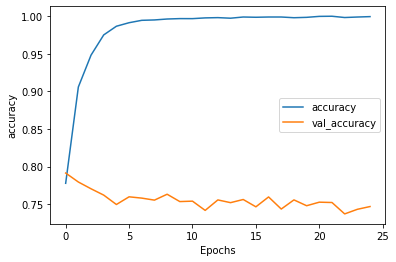

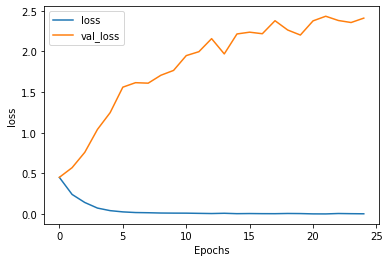

In [25]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


In [0]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


In [27]:
session.close()